In [71]:
#--------------------------------------------------------------------------------
# Module 1: Loading pickled big boi data for GAN model
#--------------------------------------------------------------------------------

import pickle
import os

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.pkl"):
    with open("Processed data/data_encoded.pkl", "rb") as file:
        data_encoded = pickle.load(file)
else:
    print("The pickled file does not exist in the specified directory.")


In [72]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

def build_generator():
    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(num_features, activation='tanh'))

    return model

generator = build_generator()
generator.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 512)               51712     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_51 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_52 (Dense)            (None, 2048)            

In [73]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

def build_discriminator():
    model = Sequential()

    model.add(Dense(1024, input_dim=num_features))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 1024)              34906112  
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_55 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_56 (Dense)            (None, 256)             

In [74]:
#--------------------------------------------------------------------------------
# Module 4: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])



In [75]:
#--------------------------------------------------------------------------------
# Module 5: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process, as it ruins the model.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = False

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using the same loss and optimizer as the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

gan.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_15 (Sequential)  (None, 34087)             72520487  
                                                                 
 sequential_16 (Sequential)  (None, 1)                 35562497  
                                                                 
Total params: 108082984 (412.30 MB)
Trainable params: 72520487 (276.64 MB)
Non-trainable params: 35562497 (135.66 MB)
_________________________________________________________________


In [76]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 200
batch_size = 200
half_batch = batch_size // 2

# Lists to hold loss and accuracy values for plotting after training
d_losses = []
d_accuracies = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses and accuracy for plotting
    d_losses.append(d_loss[0])
    d_accuracies.append(100 * d_loss[1])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")


4/4 [==============================] - 0s 17ms/step
0/200 [D loss: 0.6992661654949188 | D accuracy: 44.49999928474426] [G loss: 1.199299931526184]
4/4 [==============================] - 0s 16ms/step
1/200 [D loss: 0.7452677190303802 | D accuracy: 49.50000047683716] [G loss: 0.7768977284431458]
4/4 [==============================] - 0s 38ms/step
2/200 [D loss: 0.7546375095844269 | D accuracy: 50.0] [G loss: 0.7363373041152954]
4/4 [==============================] - 0s 16ms/step
3/200 [D loss: 0.7269665002822876 | D accuracy: 50.0] [G loss: 0.7800022959709167]
4/4 [==============================] - 0s 16ms/step
4/200 [D loss: 0.6804177463054657 | D accuracy: 53.50000001490116] [G loss: 0.9059869647026062]
4/4 [==============================] - 0s 16ms/step
5/200 [D loss: 0.6472752690315247 | D accuracy: 67.49999970197678] [G loss: 1.0186232328414917]
4/4 [==============================] - 0s 17ms/step
6/200 [D loss: 0.6229360401630402 | D accuracy: 77.50000059604645] [G loss: 1.063296556

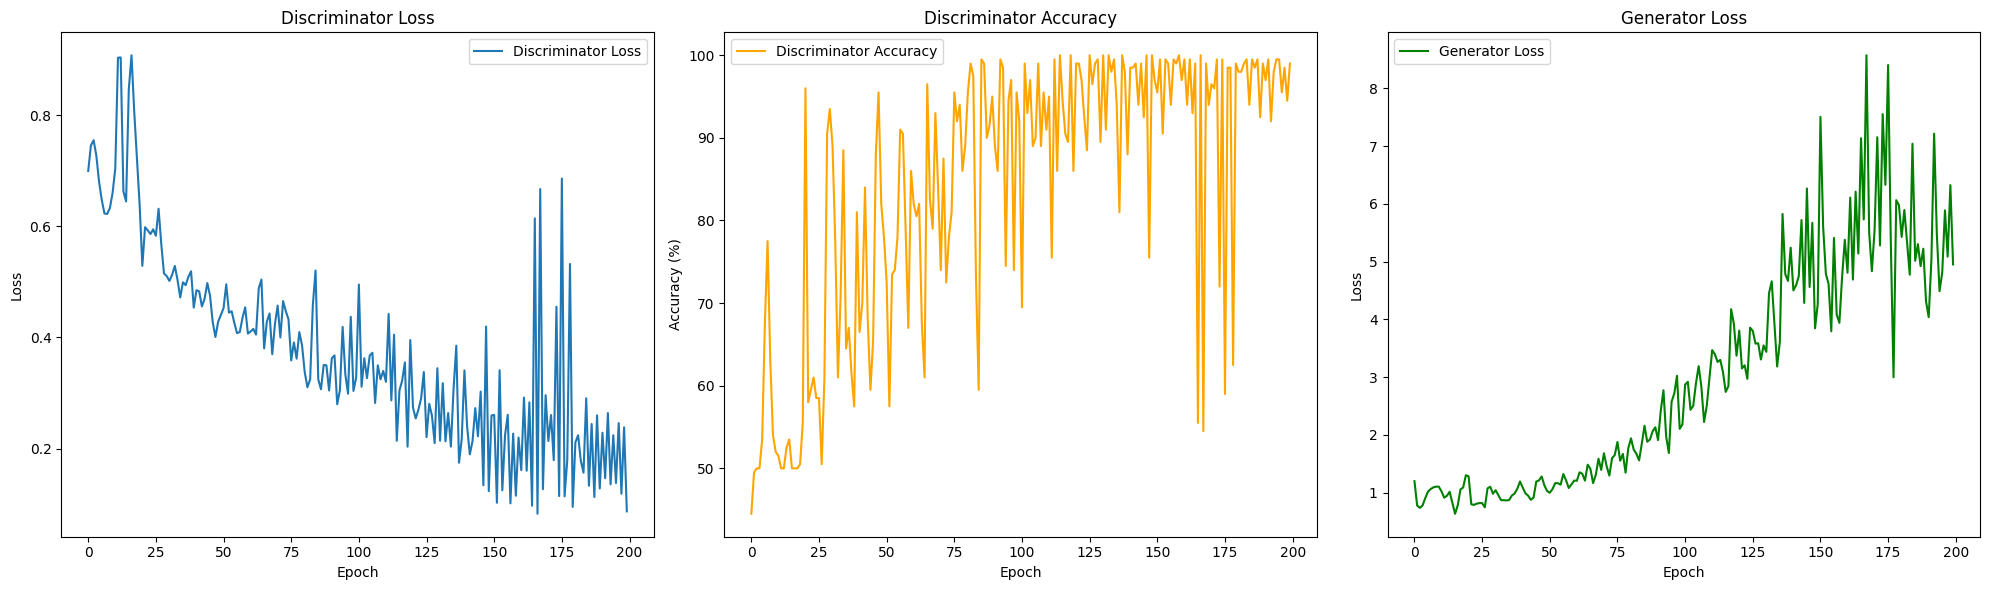

In [77]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss and Accuracy
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(20, 6))

# Plotting Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Discriminator Accuracy
plt.subplot(1, 3, 2)
plt.plot(d_accuracies, label='Discriminator Accuracy', color='orange')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [78]:
#--------------------------------------------------------------------------------
# Module 8: Display synthesied data in non-normalised format
#--------------------------------------------------------------------------------

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def generate_and_inverse_transform(generator, num_samples=20):

    # 1. Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)
    
    # 2. Inverse one-hot encoding to get original categorical columns
    for original_col in original_categorical_columns:
        one_hot_cols = [col for col in generated_df.columns if col.startswith(original_col + "_")]
        
        # Check if there are one-hot columns related to the original column
        if one_hot_cols:
            generated_df[original_col] = generated_df[one_hot_cols].idxmax(axis=1).str.replace(original_col + "_", "")
            generated_df.drop(one_hot_cols, axis=1, inplace=True)
    
    # 3. Inverse normalization to get the original values of numerical columns
    generated_df[numerical_columns] = scaler.inverse_transform(generated_df[numerical_columns])
    
    # Ensure all columns from original data are present in generated_df
    for col in data.columns:
        if col not in generated_df.columns:
            generated_df[col] = np.nan
    
    # Ensure the columns are in the same order as the original data
    generated_df = generated_df[data.columns]
    
    return generated_df

# Assuming you have your original dataframe named 'data' loaded from CSV
data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")

# 1. Recreate the scaler object
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Identify original categorical columns before one-hot encoding
original_categorical_columns = data.select_dtypes(include=['object']).columns

# 4. Call the function and print synthetic data
synthetic_data = generate_and_inverse_transform(generator)
print(synthetic_data)



1/1 [==============================] - 0s 25ms/step
        Event  Maturity Date       Rpt ID  Option Premium  \
0   New Trade            NaN  IRS47995722      556.677551   
1   New Trade            NaN  IRS42047666     2394.892334   
2   New Trade            NaN  IRS31059937     2216.556641   
3   New Trade            NaN  IRS39584479      694.625977   
4   New Trade            NaN  IRS39823382     3023.051270   
5   New Trade            NaN  IRS32439167     2252.898193   
6   New Trade            NaN  IRS32439167     1864.989990   
7   New Trade            NaN  IRS32344302     2511.799561   
8   New Trade            NaN  IRS35889995     1809.276978   
9   New Trade            NaN  IRS39921565     -308.016327   
10  New Trade            NaN  IRS32683275     1270.461914   
11  New Trade            NaN  IRS36146278     1127.982666   
12  New Trade            NaN  IRS12893403     1908.134155   
13  New Trade            NaN  IRS48151382     2240.914795   
14  New Trade            NaN  IRS